In [1]:
##########
# Author: T. Guillemin
# Adaptation of a notebook from P. Antilogus
# Goal: plot science images and overscans per amplifier and per CCD
##########

In [2]:
#system imports
import time
import sys
from sys import exit
import glob
import matplotlib.pyplot as plt
import numpy as np
import astropy.io.fits as pyfits
import matplotlib
import os
from astropy.visualization import (ImageNormalize,PercentileInterval,HistEqStretch)
from mpl_toolkits.axes_grid1 import make_axes_locatable
import gc 

# load the frame analysis code of eochar (from sps folder, no need to have it locally)
%run -i  /sps/lsst/users/antilog/GitHub/eochar/python/lsst/eochar/bot_frame_op.py

#selection of the .fits file
######method 1
#select one file by hand
files_to_read='/sps/lsst/groups/FocalPlane/SLAC/run5/13161/bias_bias_013/MC_C_20211212_000150_R14_S22.fits'

######method 2
#list of files
#run='13161'
#raft='R14'
#cd='S21'
#directory='dark_dark_*'
#file='MC_C_*_'+raft+'_'+ccd+'.fits'
#files_to_read='/sps/lsst/groups/FocalPlane/SLAC/run5/'+run+'/'+directory+'/'+file

file_list=glob.glob(files_to_read)
file_list.sort()
print('Selected files:')
print(file_list)

#define output folder (useful to be on the web) 
output_data='/sps/lsst/users/tguillem/web/tutorial/direct/' 

Selected files:
['/sps/lsst/groups/FocalPlane/SLAC/run5/13161/bias_bias_013/MC_C_20211212_000150_R14_S22.fits']


In [3]:
#compute unbiased image (used only for the image dimensions first)
UnBias='2D'
FileUnBias=InFile(dirall=file_list,Slow=False,verbose=False,Bias=UnBias) 

#get the image area ( overscan excluded ) using the first file 
first_col=FileUnBias.all_file[0].first_col
first_s_over=FileUnBias.all_file[0].first_s_over
first_line=FileUnBias.all_file[0].first_line
first_p_over=FileUnBias.all_file[0].first_p_over
amp_y_size=len(FileUnBias.all_file[0].Image[0][:,0])
amp_x_size=len(FileUnBias.all_file[0].Image[0][0,:])
im_y_size=first_p_over-first_line
im_x_size=first_s_over-first_col

print('Number of lines read=',amp_y_size,' Number of colomns read=',amp_x_size)
print('Number of lines in Image area=',im_y_size,' Number of colomns in Image area=',im_x_size)
print('First line in Image area=',first_line,' First column in Image area=',first_col)

Number of lines read= 2048  Number of colomns read= 576
Number of lines in Image area= 2002  Number of colomns in Image area= 512
First line in Image area= 0  First column in Image area= 10


In [4]:
###useful functions
def SaveFig(fig,rawPlotFile,run_cur='',raft_cur='',ccd_cur='',hdu=0):
    if hdu<1 : 
        root_plt=os.path.join(output_data,run_cur,raft_cur,ccd_cur)
    else : 
        hdu_cur='%d' % (hdu)
        root_plt=os.path.join(output_data,run_cur,raft_cur,ccd_cur,hdu_cur)
    # 
    PlotFile=rawPlotFile.replace('.','_')
    PlotFile=PlotFile.replace(' ','_')
    os.makedirs(root_plt,exist_ok=True)
    plotfile=os.path.join(root_plt,PlotFile)
    print ('PlotFile=',plotfile)
    fig.savefig(plotfile,bbox_inches='tight')
    plt.close(fig) 
    return

def SingleImageIR(image,first_col=first_col,first_cover=first_s_over,first_line=first_line,first_lower=first_p_over):
        # Display an IR2 image , with amplifiers set at the right place ...there is a DM version which does this better...
        # but here you are in stand alone 
        # the default associated to the image area (pre-overscan excluded) are for e2v IR2 files 
        #
        col_size=first_cover-first_col
        line_size=first_lower-first_line
        #
        spf=np.zeros((line_size*2,col_size*8))
        for i in range(16) :
            if i<8 :
                xx=i*col_size-1
                yy=0
                for x in range(first_col,first_cover) :  
                    spf[yy:yy+line_size,xx+col_size-(x-first_col)]=image[i][first_line:first_lower,x]
            else :
                xx=(15-i)*col_size
                yy=-1
                for y in range(first_line,first_lower) :  
                    spf[yy+2*line_size-(y-first_line),xx:xx+col_size]=image[i][y,first_col:first_cover]
                    
        return spf
###end functions

In [5]:
#select first file
ifile=file_list[0]
    
#acces directly the fits file image 
fits=pyfits.open(ifile)

# print the image main information 
print(fits[0].header.tostring(sep='\n', endcard=True, padding=True))

SIMPLE  =                    T / Java FITS: Fri Dec 10 20:22:19 PST 2021        
BITPIX  =                    8 / bits per data value                            
NAXIS   =                    0 / number of axes                                 
EXTEND  =                    T / Extensions are permitted                       
DATE    = '2021-12-12T22:12:19.745' / Creation Date and Time of File            
MJD     =   59560.925228530075 / Modified Julian Date that the file was written 
RUNNUM  = '13161   '           / The Run Number                                 
CCD_MANU= 'E2V     '           / CCD Manufacturer                               
CCD_TYPE= 'CCD250  '           / CCD Model Number                               
TESTTYPE= 'BIAS' / BIAS, DARK, FE55, FLAT, LAMBDA, PERSISTENCE, SPOT, SFLAT_<lam
IMGTYPE = 'BIAS    '           / BIAS, DARK, FE55, FLAT, FLAT_<lam>, SPOT, PPUMP
DETSIZE = '[1:4096,1:4004]'                                                     
EXPTIME =                  0

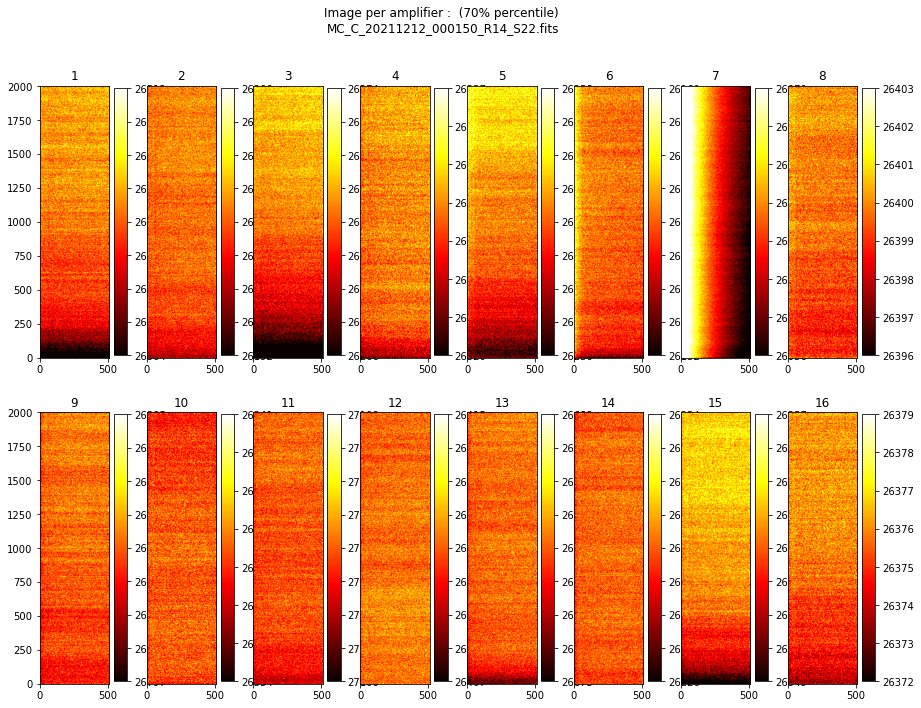

In [6]:
# plot the raw image / amplifier
fig=plt.figure(figsize=[15,11])
title='Image per amplifier :  (70%s percentile) \n%s' % ('%',os.path.basename(ifile))
image_txt='RawImagePerAmp'
plt.suptitle(title)
for i in range(16) :
    norm = ImageNormalize(fits[i+1].data[first_line:first_p_over,first_col:first_s_over], interval=PercentileInterval(70.))
    plt.subplot(2,8,i+1,title=i+1)
    plt.imshow(fits[i+1].data[first_line:first_p_over,first_col:first_s_over],cmap='hot',origin='lower',norm=norm)
    if not(i%8 ==0) :
        figure=plt.gca()
        y_axis = figure.axes.get_yaxis()
        y_axis.set_visible(False)
    plt.colorbar()
#SaveFig(fig,image_txt,run_cur=run,raft_cur=raft,ccd_cur=ccd,hdu=0)

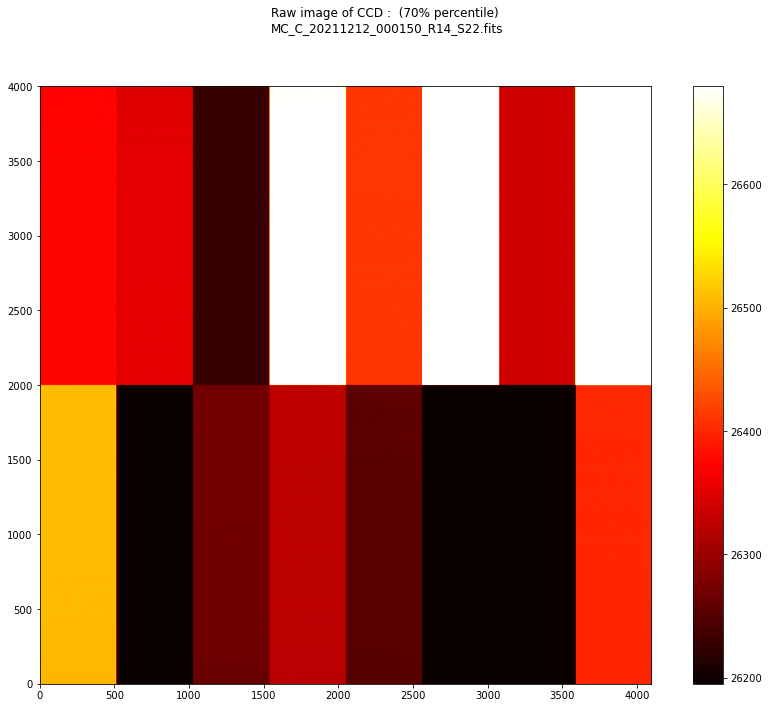

In [7]:
#plot all the amplifiers on one image (no overscan correction and no master bias substraction)
nb_amp=16

fig=plt.figure(figsize=[15,11])
title='Raw image of CCD :  (70%s percentile) \n%s' % ('%',os.path.basename(ifile))
plt.suptitle(title)

#create an image (fix the 0/1 index issue of the object fits)
image_tmp=[]
for i in range(nb_amp):
    image_tmp.append(fits[i+1].data)
    
image = SingleImageIR(image_tmp)
norm = ImageNormalize(image, interval=PercentileInterval(70.))
plt.imshow(image,cmap='hot',origin='lower',norm=norm)
plt.colorbar()
image_txt='CCD_RawImage'
#SaveFig(fig,image_txt,run_cur=run,raft_cur=raft,ccd_cur=ccd,hdu=0) 

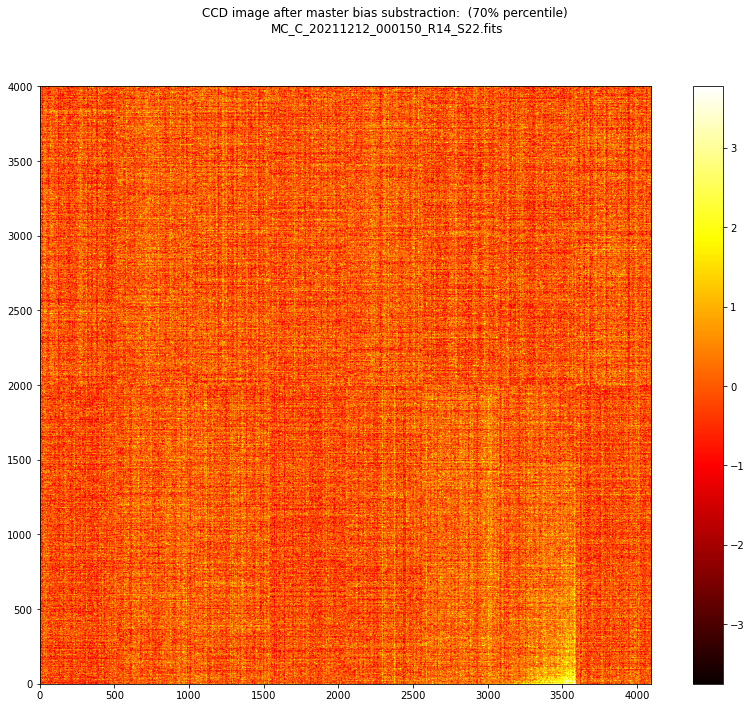

In [8]:
#plot all the amplifiers on one image after a master bias substraction
nb_amp=16

fig=plt.figure(figsize=[15,11])
title='CCD image after master bias substraction:  (70%s percentile) \n%s' % ('%',os.path.basename(ifile))
plt.suptitle(title)

image = SingleImageIR(FileUnBias.all_file[0].Image)
norm = ImageNormalize(image, interval=PercentileInterval(70.))
plt.imshow(image,cmap='hot',origin='lower',norm=norm)
plt.colorbar()
image_txt='CCD_Image'
#SaveFig(fig,image_txt,run_cur=run,raft_cur=raft,ccd_cur=ccd,hdu=0)

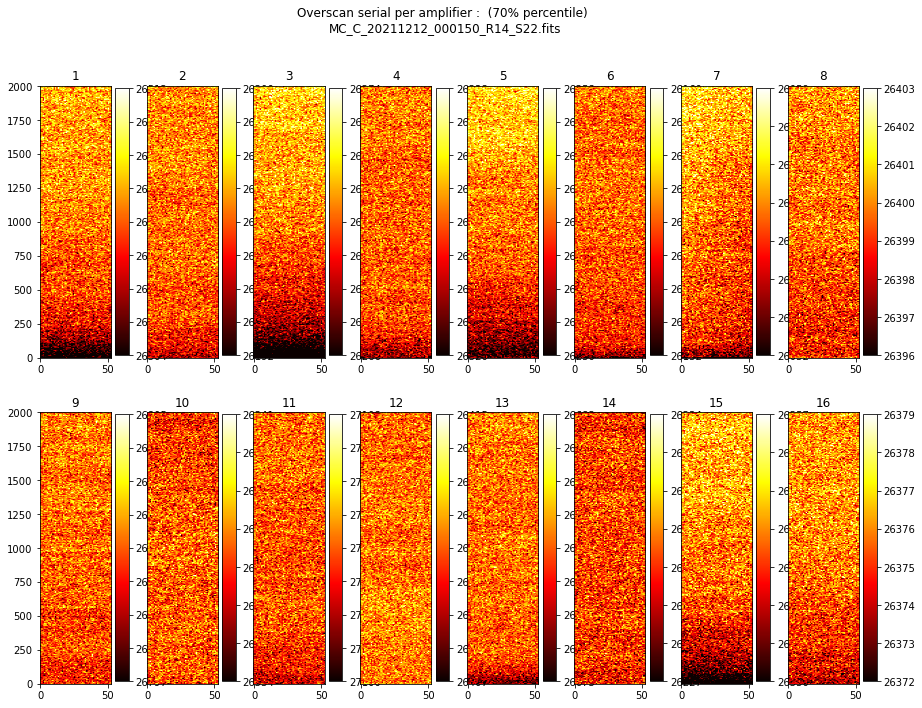

In [9]:
#access the serial overscan pixels   
fig=plt.figure(figsize=[15,11])
title='Overscan serial per amplifier :  (70%s percentile) \n%s' % ('%',os.path.basename(ifile))
image_txt='RawOverscanSerialPerAmp'
plt.suptitle(title)
for i in range(16) :
    norm = ImageNormalize(fits[i+1].data[first_line:first_p_over,first_s_over+1:amp_x_size], interval=PercentileInterval(70.))
    ax = plt.subplot(2,8,i+1,title=i+1)
    plt.imshow(fits[i+1].data[first_line:first_p_over,first_s_over+1:amp_x_size],cmap = 'hot',origin='lower',norm=norm)
    if not(i%8 ==0) :
        figure=plt.gca()
        y_axis = figure.axes.get_yaxis()
        y_axis.set_visible(False)
    plt.colorbar()
    ax.set_aspect('auto')
#SaveFig(fig,image_txt,run_cur=run,raft_cur=raft,ccd_cur=ccd,hdu=0)

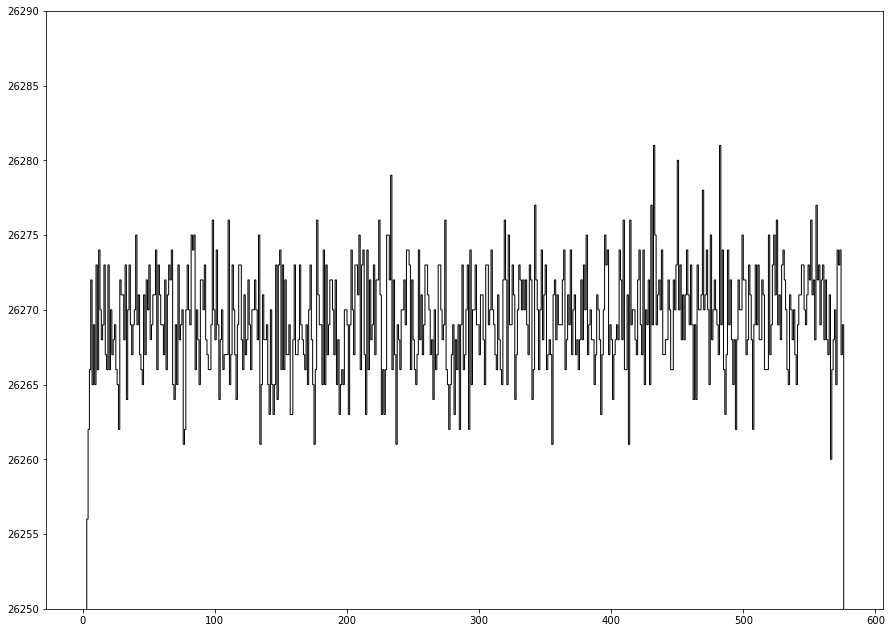

In [10]:
#1D distribution of a full line of one amplifier (including prescan and overscan regions)

#select line 750
line=fits[3].data[750,:]

n_bins=len(line)
bin_x=np.empty(n_bins)
xedges=np.empty(n_bins+1)
for ix in range(n_bins):
    bin_x[ix]=ix+0.5
    xedges[ix]=ix+1
xedges[n_bins]=n_bins+1

plt.figure(figsize=[15,11])
plt.hist(bin_x, weights=line, bins=xedges, histtype='step', color = 'black')
plt.ylim([26250, 26290])
plt.savefig(output_data+'line_of_pixels.png') 

Exercices:
1) 1D distribution of the mean per line of one amplifier for the science image only
2) By-hand subtraction of the mean per amplifier before assembling the amplifiers in one CCD image